In [46]:
import skimage
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import feature
from skimage import io
from skimage import measure
from skimage import morphology
from skimage.color import rgb2gray, rgba2rgb
from ellipse import LsqEllipse
from matplotlib.patches import Ellipse
from skimage.transform import rescale

# Count Collembola in petri disk
We are given a photo of a petri disk with coloured soil in it. In the soil there are very tiny [collebola](https://en.wikipedia.org/wiki/Springtail) larvae and slightly bigger collebola adults. The goal is to count them separately.
On the provided image it is said to be 301 larvae and 9 adults (I haven't counted them myself to double check the numbers.)

We start by extracting the region of interest (ROI) of the petri disk. First we load and display the image. We turn it to grayscale for processing and save the height and width in variales `h` and `w`.

In [2]:
img = io.imread("IMG_0048.JPG")
grayscale = rgb2gray(img)
h, w = grayscale.shape

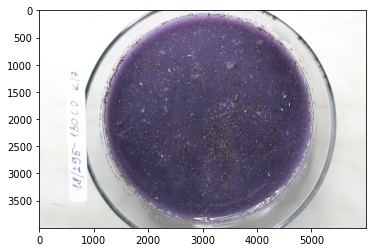

In [3]:
plt.imshow(img)

To segment the ROI we downscale the image for fast processing. We use the variable `scale` to specify the downscaling level. Then we smooth it to produce better edge detection using the Canny edge detector.

In [4]:
scale = 10
small = rescale(grayscale, 1/scale, anti_aliasing=False)

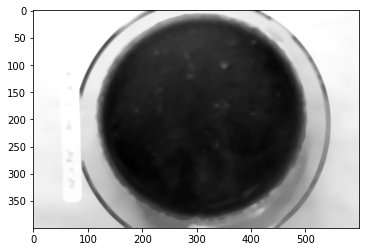

In [5]:
smooth = filters.median(small, selem=np.ones((10, 10)))
plt.imshow(smooth, cmap='gray')

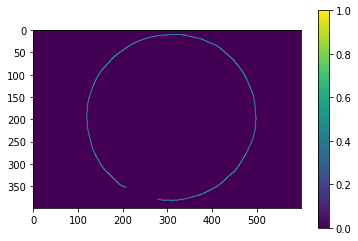

In [90]:
edges = skimage.feature.canny(smooth, sigma=8)
plt.imshow(edges)
plt.colorbar()

We have found the contour we were looking for, but it's not complete. One way of getting a binary mask with all `True`s in the circle is fitting a circle to the found edge points. Using the parameters of the fitted circle we can create the binary mask.

First we make sure the values are binary. Then we extract the points to arrays of `x` and `y` coordinates for the fitting. We use the [lsq-ellipse](https://github.com/bdhammel/least-squares-ellipse-fitting) library to fit an ellipse to the points. The advantage of an ellipse is perspective distortion doesn't affect badly the results.

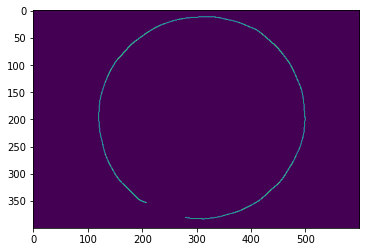

In [92]:
binary = edges > 0
plt.imshow(binary)
plt.show()

In [93]:
x,y = np.where(binary == 1)

In [94]:
lsqe = LsqEllipse()
lsqe.fit(np.vstack((x,y)).T)  # fit ellipse to contour points

In [95]:
# the parameters of the fitted ellipse
center, width, height, phi = lsqe.as_parameters()

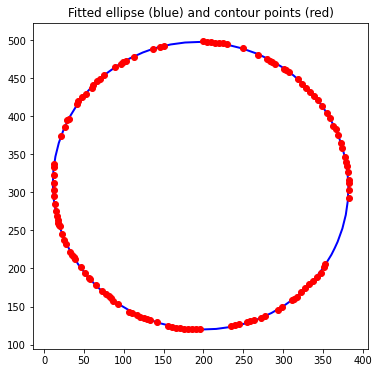

In [99]:
ellipse = Ellipse(xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
    )

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
every_x = 10 # plotting every 10th point only to see the ellipse too
ax.plot(x[::every_x], y[::every_x], "ro")
ax.add_patch(ellipse)   # plot the ellipse
plt.title("Fitted ellipse (blue) and contour points (red)")
plt.show()

Having the parameters of the fitted ellipse we can construct the binary mask where all pixels inside the petri disk are `True` and `False` outside. For simplicity, here we average the height and width of the ellipse to approximate it with a circle.

We exclude to high intensity, close-to-boundary pixels using variable `margin` (see cell below). This will help the classification later, as the collembola are small white ovals on the image. The excluded boundary has a glitter that is difficult to distinguish from collebola.

Since we are about to apply the mask to the original high resolution (HR) input image, we use `scale` to enlarge the fitted parameters.

The original HR image is RGB with 3 colour channels. To easily mask it we need the same binary mask in all 3 channels. To do so we use numpy's `expand_dims` to add a dummy dimension to the end of the 2D binary mask, then we apply `broadcast_to` method to repeat the 2D binary mask having the same mask for 3 colour channels.

*Note: at the end we'll use the grayscale version of the RGB image. If we have nothing to do with the colour image, the above steps to extend the mask dimension to have the same mask for all colour channels is unnecessary. We can simply turn the RGB input image to grayscale and apply the 2D mask on the gray image.*

In [69]:
Y, X = np.ogrid[:h, :w]
radius = (width + height) / 2
margin = 0.95
distance = np.sqrt((X - scale*center[1])**2 + (Y - scale*center[0])**2)
mask = distance <= scale*radius*margin

(4000, 6000)


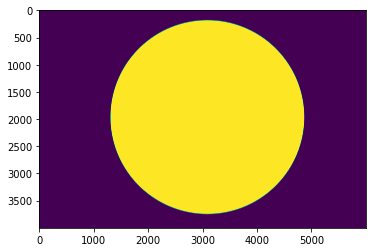

In [100]:
print(mask.shape)
plt.imshow(mask)
plt.show()

In [101]:
# turn mask's shape from (4000, 6000) to (4000, 6000, 1)
expanded_mask = np.expand_dims(mask, axis=2)
print(expanded_mask.shape)

(4000, 6000, 1)


In [102]:
# copy the original 2D binary mask to all colour channels
rgb_mask = np.broadcast_to(expanded_mask, img.shape)
print(rgb_mask.shape)

(4000, 6000, 3)


In [73]:
# Now the mask has the same dim as the RGB image, we can mask now
ROI = img * rgb_mask

ROI_gray = rgb2gray(ROI)

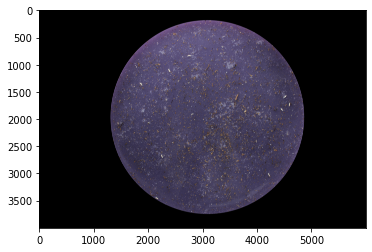

In [74]:
plt.imshow(ROI)

## Fit model parameters on a smaller patch:
We have an extracted patch from the top left side of the circle. We load this patch to experiment with the optimal model parameters before running the model on the HR image.
On the extracted patch I counted 2 adults and 36 larvae.

We turn the patch to grayscale and check the histogram of it. Using the histogram we can pick a good starting point for the subsequent thresholding.

Now the higher intensities correspond to either Collembola or some noise. The noise can be some glitter of water bubbles for example, or tiny glittering crystals of sand.

Our approach is to threshold the image and only keep high intensity regions. Then applying contour detection we further threshold the high intensity regions based on the contour length. The largest contour length will correspond to Collembola adults. A medium lenght will correspond to larvae, while the smallest are typically noise.

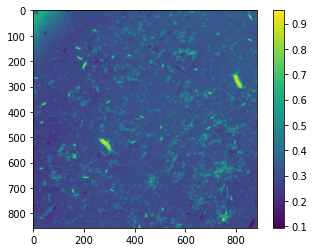

In [149]:
patch = io.imread("patch.png")
gray = rgb2gray(rgba2rgb(patch))
plt.imshow(gray)
plt.colorbar()
plt.show()

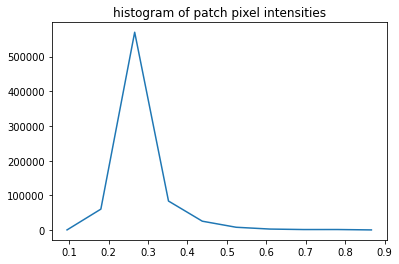

In [104]:
histogram, bin_edges = np.histogram(gray)
plt.plot(bin_edges[0:-1], histogram)
plt.title("histogram of patch pixel intensities")
plt.show()

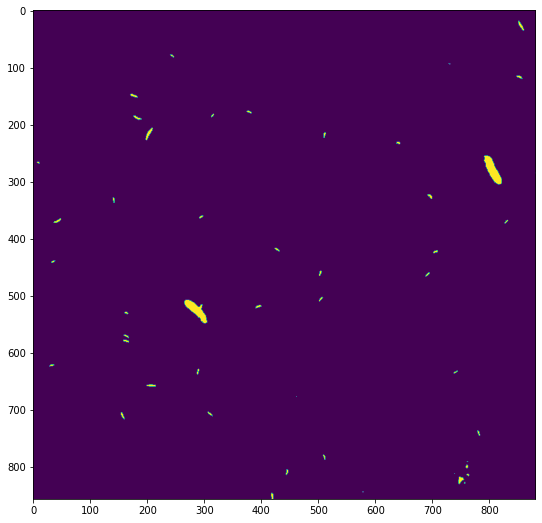

In [63]:
shapes = gray > .75 # thresholding based on histogram 
                    # and some experiments
masked = shapes * gray
plt.subplots(figsize=(9, 9))

plt.imshow(shapes)

In [64]:
contours = measure.find_contours(shapes, 0.8)
lengths = []
for contour in contours:
    lengths.append(len(contour))
lengthes = np.array(lengths)
plt.hist(lengths, 42)

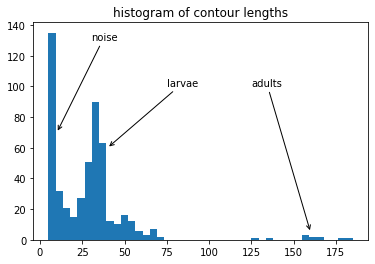

In [120]:
plt.hist(lengths, 42)
plt.title("histogram of contour lengths")
XYs = [(10, 70), (40, 60), (160, 5)]
XYtexts = [(30, 130), (75, 100), (125, 100)]
texts = ["noise", "larvae", "adults"]
for i in range(3):
    plt.annotate(texts[i], xy=XYs[i], 
            xycoords="data", xytext=XYtexts[i],
            textcoords="data", arrowprops=dict(
            arrowstyle="->", connectionstyle="arc3"))
plt.show()

Now we have an intensity threshold we can use (0.75), and the contour length characteristics. We can put together all these, and display the results. We use cyan colour for the larvae and red for the adults. We also print the counted number of children (larvea) and adults.

Parents: 2, children: 39


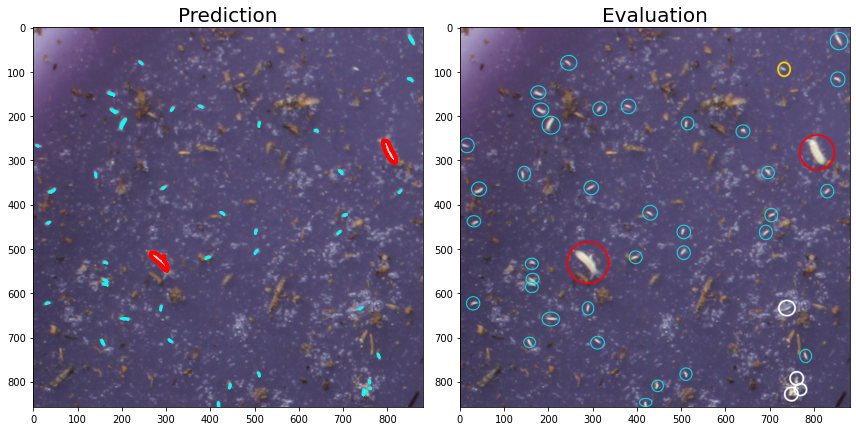

In [148]:
img2 = io.imread("patch_gt.png")
shapes = gray > .75
contours = measure.find_contours(shapes, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(patch, cmap=plt.cm.gray)
c=0
p=0
for contour in contours:
    if 150 > len(contour) > 13:  # children
        c+=1
        ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color="cyan")
    elif len(contour) > 150:   # adults
        p+=1
        ax[0].plot(contour[:, 1], contour[:, 0], linewidth=4, color="red")
ax[0].set_title("Prediction", size=20)
ax[1].imshow(img2)
ax[1].set_title("Evaluation", size=20)
plt.tight_layout()
print(f"Parents: {p}, children: {c}")
plt.show()

We have 1 false negative marked with yellow on the right, and 4 false positives marked with white on the bottom-right part of the rigth image. 

### Alternative approach:
An alternative approach doesn't use the contour lengths, but looks for local maxima in the thresholded intensity map. First we look for very high intesities that correspond to the adults. Then we use a lower intensity threshold and exclude points being very close to the previously found adults.

*Note: This alternative approach has lower accuracy. The first method (above) is recommended.*

Adults: 2


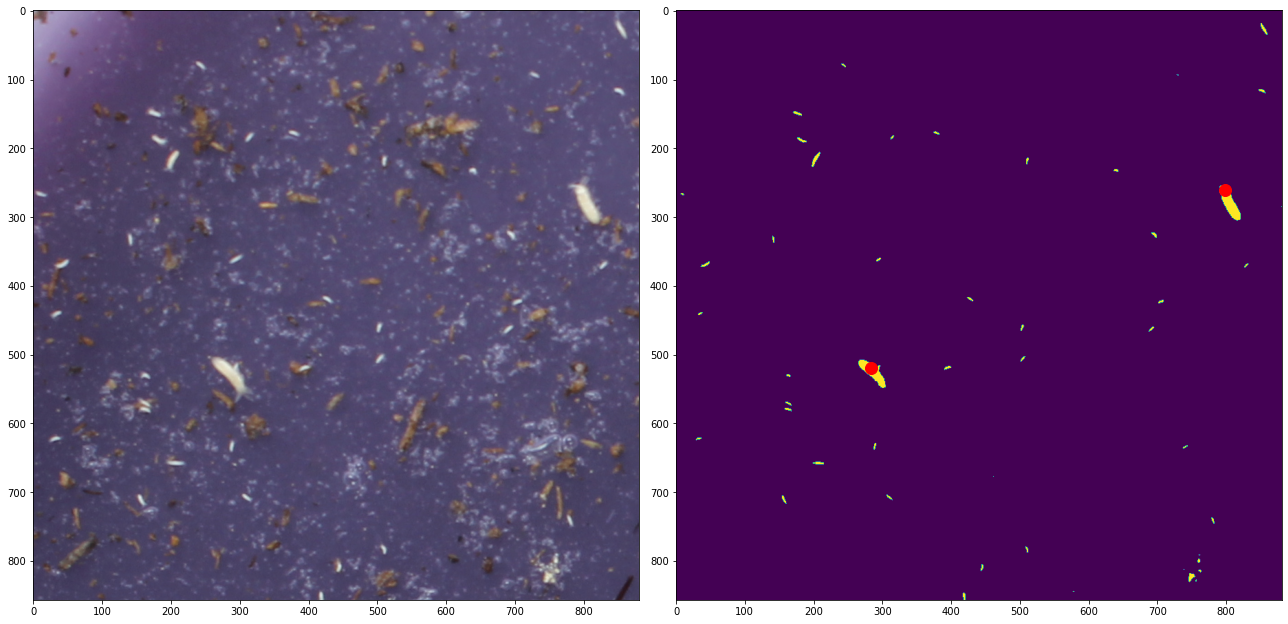

In [122]:
mask = gray > .92
masked = gray * mask
adults = feature.peak_local_max(masked, indices=True, min_distance=5)
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].imshow(patch)
ax[1].plot(adults[:,1], adults[:,0], "ro", markersize=12);
ax[1].imshow(shapes)
plt.tight_layout()
print("Adults:", len(adults))

In [123]:
def exclude_adults(children, adults, threshold=50):
    """Excludes points in `children` that are closer than 
    `threshold` pixels to any of the points in `adults`"""
    mask = np.array([True]*len(children))
    for adult in adults:
        current_mask = np.sqrt(np.sum((children - adult)**2, axis=1)) > threshold
        mask = mask * current_mask
    return children[mask]

Children: 43


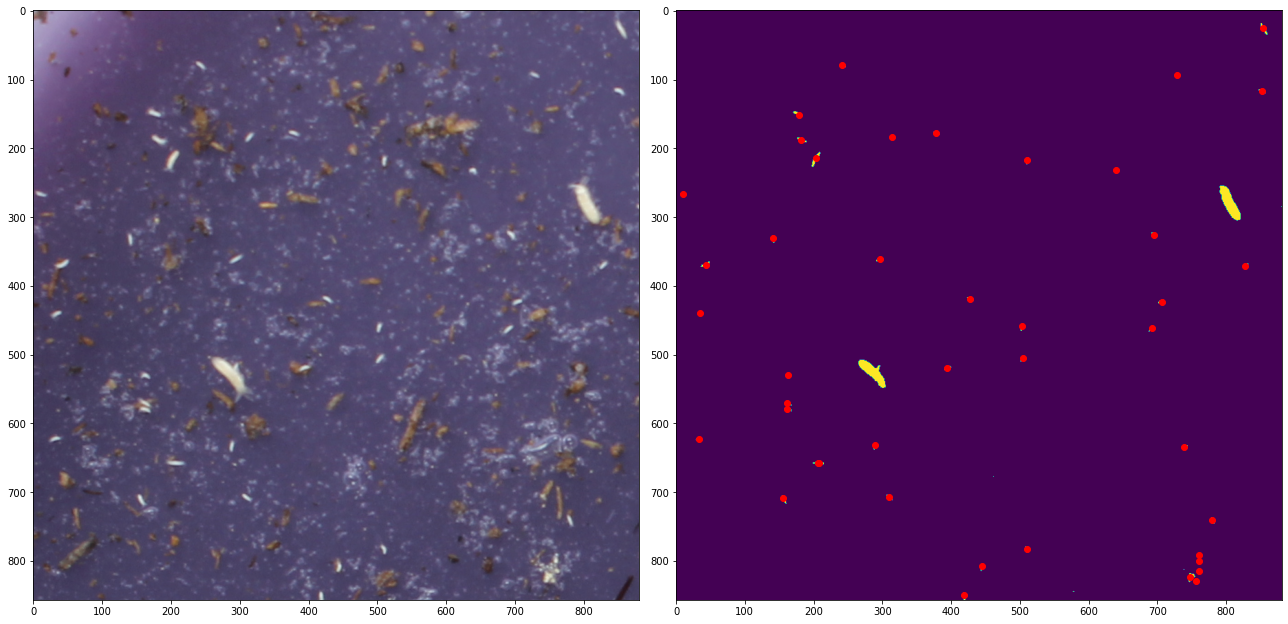

In [125]:
mask = gray > .76
masked = mask * gray
children = feature.peak_local_max(masked, indices=True, min_distance=5)
children = exclude_adults(children, adults)
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].imshow(patch)
ax[1].plot(children[:,1], children[:,0], "ro");
ax[1].imshow(shapes)
plt.tight_layout()
print("Children:", len(children))

The alternative method has lower accuracy because it can't exclude tiny glittering points eg. 4-5 such points on the bottom right corner on the image above.

# Run model on full image
From the first half of the notebook we have the segmented region of interest (ROI). We now apply the contour lenght-based method on the ROI. Then we plot the histogram of contour lengths. This is testing time, we don't change the model parameters based on the histogram. Since we have a larger image we have more noise, the separation of children from noise is less clear.

Parents: 9, children: 337


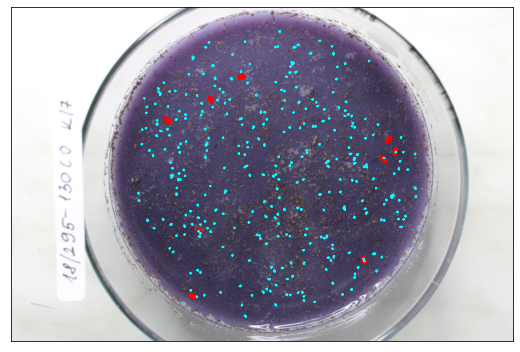

In [126]:
shapes = ROI_gray > .75
contours = measure.find_contours(shapes, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(img, cmap=plt.cm.gray)
c=0
p=0
for contour in contours:
    if 150 > len(contour) > 13:
        c+=1
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="cyan")
    elif 200 > len(contour) > 150:
        p+=1
        ax.plot(contour[:, 1], contour[:, 0], linewidth=4, color="red")

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

print(f"Parents: {p}, children: {c}")
plt.show()

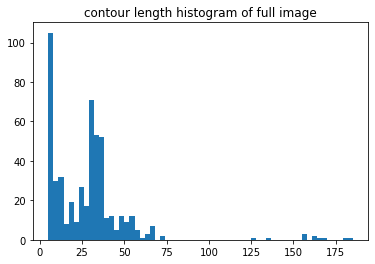

In [129]:
lengths = []
for contour in contours:
    lengths.append(len(contour))
lengthes = np.array(lengths)
plt.hist(lengths, 60)
plt.title("contour length histogram of full image")
plt.show()

The parameters fitted to the small patch worked relatively well on the full image. The model has 100% accuracy for the adults, but over-predicts the children by 36 (~10% extra). More images would be needed for futher and more precise evaluation. For the large image we don't have a detailed evalutaion with the false positives and false negatives.

Some considerations regarding the applicability of the model:
1. The model relies on intensities. For this reason if the lighting of a new image is different, then the pre-defined intensity thresholds can be bad choices. If the photos are taken with similar lighting and using the same settings, then the model is more suited for the task.
2. For adults the model is promising, but it gave a too large number for the children. With more images a better intensity/contour length threshold could be found. It is also possible that there is no optimal parameter and we'll always have some false positives (glittering bubbles/sand). It is possible that the fraction of such false positives doesn't vary much across images. In this ideal scenario we can simply adjust the reported number of children (eg. reporting 90% of the counted number).

The model could be further improved with a new module recongising the label on the left of the petri disk, and using OCR the text could be read. And the results could be saved with that name.

### Below is the alternative approach for the large image.
For the large image the alternative approach is even worse than it was for the patch.

Adults: 91


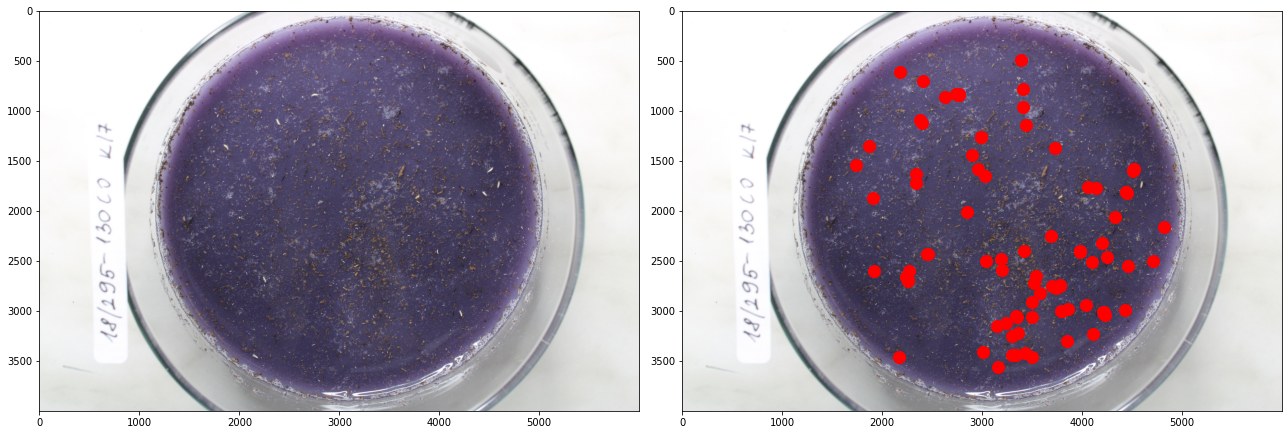

In [134]:
mask = ROI_gray > .9
masked = ROI_gray * mask
adults = feature.peak_local_max(masked, indices=True, min_distance=5)
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].imshow(img)
ax[1].plot(adults[:,1], adults[:,0], "ro", markersize=12);
ax[1].imshow(img)
plt.tight_layout()
print("Adults:", len(adults))

Children: 368


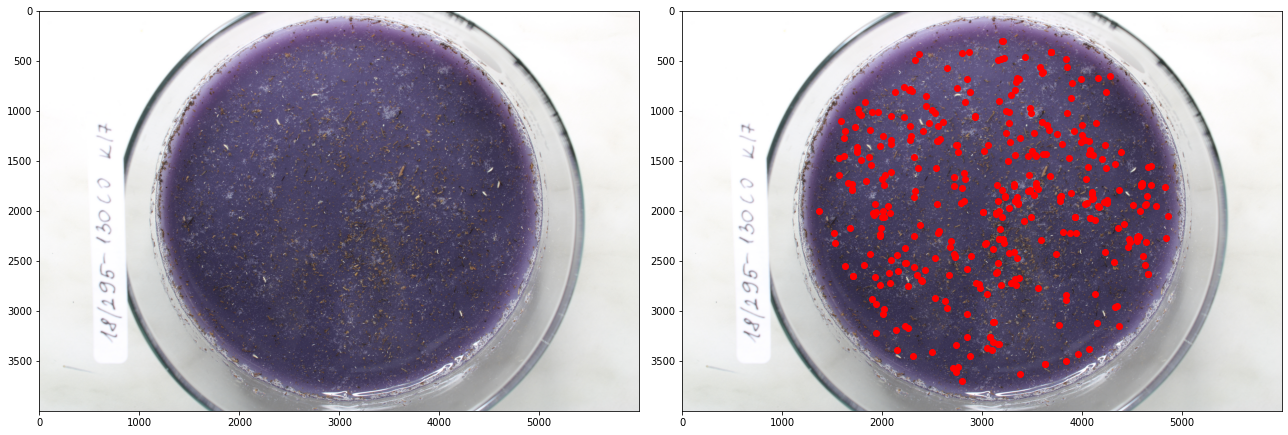

In [135]:
mask = ROI_gray > .76
masked = mask * ROI_gray
children = feature.peak_local_max(masked, indices=True, min_distance=5)
children = exclude_adults(children, adults)
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].imshow(img)
ax[1].plot(children[:,1], children[:,0], "ro");
ax[1].imshow(img)
plt.tight_layout()
print("Children:", len(children))

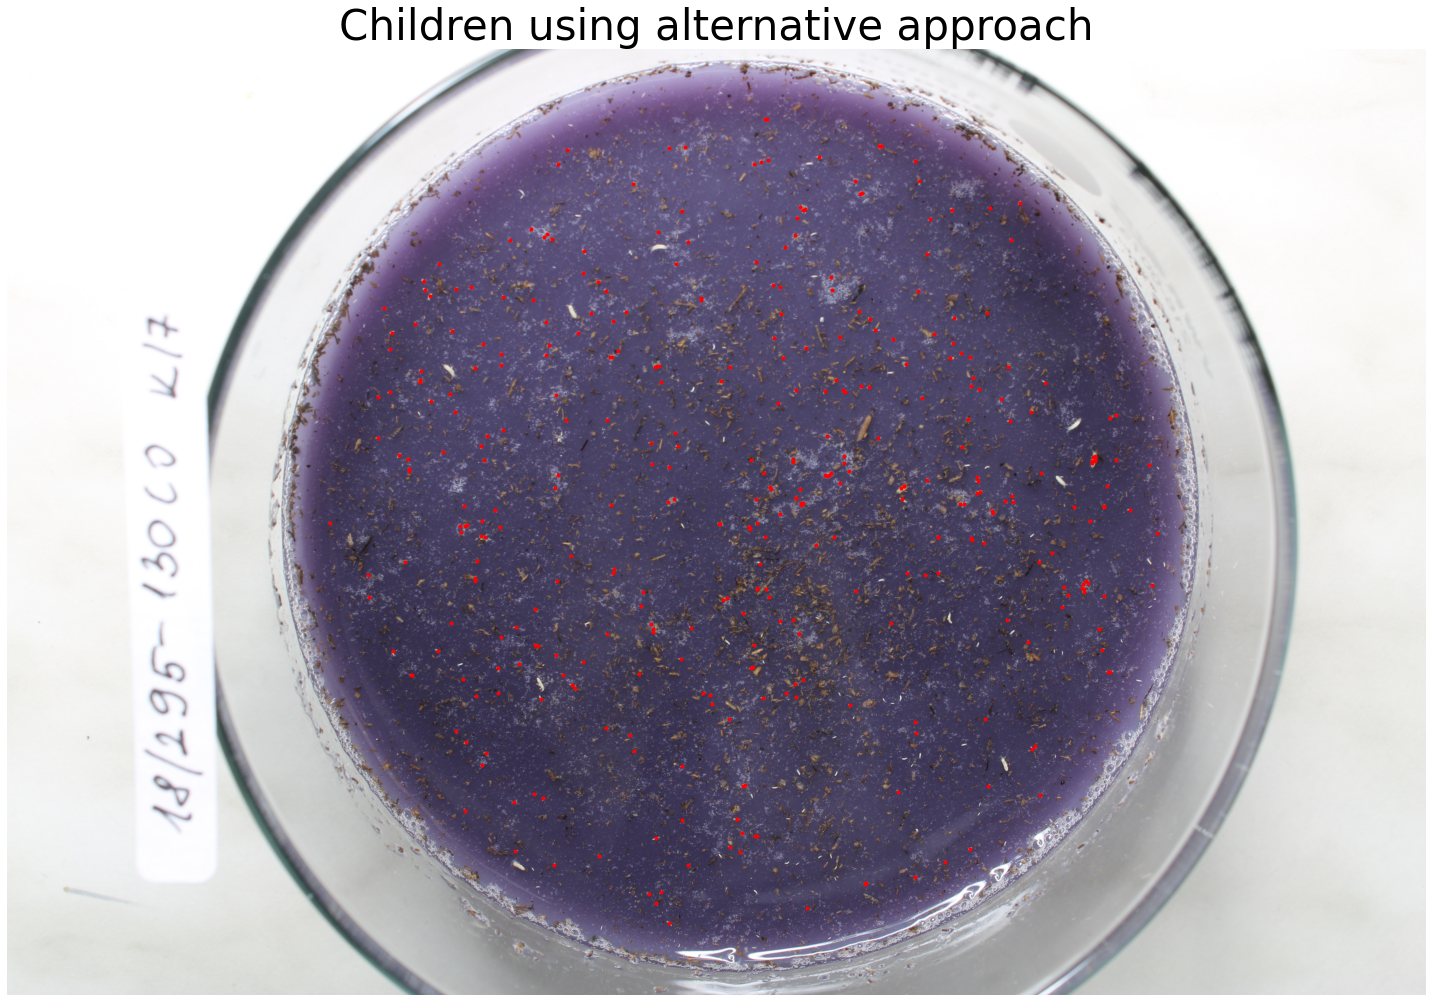

In [136]:
plt.subplots(figsize=(20, 20))
plt.imshow(img)
plt.plot(children[:,1], children[:,0], "r.")
plt.axis("off")
plt.title("Children using alternative approach", size=42)
plt.tight_layout()
#plt.savefig("output.png", quality=95)